In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from   scipy import stats, special, integrate

print("Importing third party libraries")
import dill as pickle
import tensorflow as tf
import keras.backend as K

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

target_observable = "TOYVAR1"

c_vals      = np.array([0, -10, -5, -1, 1, 5, 10]) / 20.
mu_limits   = [40, 500]
num_samples = int(1e4) # int(2e5)
    

In [3]:
#  Model config

output_size_per_stage     = 25
max_epochs                = 1000
batch_sizes               = [1000]
early_stopping_patience   = 5
early_stopping_min_delta  = 0
validation_split          = 0.4

white_linear_fraction_data_space   = .9
white_linear_fraction_latent_space = 0.       # Keep 0, otherwise we get hard boundaries on latent space
whitening_num_points               = 200

learning_rate  = 1e-3       # 0.01 for SGD or 0.001 otherwise
optimiser      = "adam"      # SGD, Adam or AdaDelta
save_plots     = True


In [4]:
#  PDF config (toy 1)

'''def mu_pdf (mu, c=0) :
    mu_prime = (mu - mu_limits[0]) / (mu_limits[-1] - mu_limits[0])
    c_prime  = np.fabs(c) * 40.
    pdf_zero = 1. / (mu_prime + 1.) - 0.5
    modifier = 1 + 2*c_prime*mu_prime
    integral = (mu_limits[-1] - mu_limits[0]) * ((1 - 2*c_prime) * np.log(2) + 1.5*c_prime - 0.5)
    return pdf_zero * modifier / integral

def mu_cdf (mu, c=0) :
    mu_prime = (mu - mu_limits[0]) / (mu_limits[-1] - mu_limits[0])
    c_prime  = np.fabs(c) * 40.
    int_first_part = (1-2*c_prime) * np.log(mu_prime+1)
    int_sec_part   = (2*c_prime - 0.5) * mu_prime
    int_third_part = -0.5 * c_prime * mu_prime * mu_prime
    integral = (1 - 2*c_prime) * np.log(2) + 1.5*c_prime - 0.5
    return (int_first_part + int_sec_part + int_third_part) / integral

def sample_pdf (n_sample, c=0, mu_resolution=0.1) :
    mu  = np.linspace(mu_limits[0], mu_limits[-1], 1+int((mu_limits[-1]-mu_limits[0])/mu_resolution))
    cdf = mu_cdf(mu, c)
    u   = np.random.uniform(size=(n_sample,))
    return np.interp(u, cdf, mu)'''


'def mu_pdf (mu, c=0) :\n    mu_prime = (mu - mu_limits[0]) / (mu_limits[-1] - mu_limits[0])\n    c_prime  = np.fabs(c) * 40.\n    pdf_zero = 1. / (mu_prime + 1.) - 0.5\n    modifier = 1 + 2*c_prime*mu_prime\n    integral = (mu_limits[-1] - mu_limits[0]) * ((1 - 2*c_prime) * np.log(2) + 1.5*c_prime - 0.5)\n    return pdf_zero * modifier / integral\n\ndef mu_cdf (mu, c=0) :\n    mu_prime = (mu - mu_limits[0]) / (mu_limits[-1] - mu_limits[0])\n    c_prime  = np.fabs(c) * 40.\n    int_first_part = (1-2*c_prime) * np.log(mu_prime+1)\n    int_sec_part   = (2*c_prime - 0.5) * mu_prime\n    int_third_part = -0.5 * c_prime * mu_prime * mu_prime\n    integral = (1 - 2*c_prime) * np.log(2) + 1.5*c_prime - 0.5\n    return (int_first_part + int_sec_part + int_third_part) / integral\n\ndef sample_pdf (n_sample, c=0, mu_resolution=0.1) :\n    mu  = np.linspace(mu_limits[0], mu_limits[-1], 1+int((mu_limits[-1]-mu_limits[0])/mu_resolution))\n    cdf = mu_cdf(mu, c)\n    u   = np.random.uniform(size=(n

In [5]:
#  PDF config (toy 2)

stored_integrals = {}

def mu_pdf_unnormed (mu, c=0) :
    mu_prime = (np.log(mu) - np.log(mu_limits[0])) / (np.log(mu_limits[-1]) - np.log(mu_limits[0]))
    c_prime  = np.fabs(c)      #  0.05 * np.fabs(c)
    pdf_zero = 1. / np.power(mu_prime + 1., 8) - (1./np.power(2., 8))
    modifier = 1. + c_prime*stats.norm.pdf(mu_prime, loc=1, scale=0.1)
    return pdf_zero * modifier

def get_integral (c, n=100) :
    global stored_integrals
    if c not in stored_integrals :
        stored_integrals[c] = integrate.fixed_quad(lambda x : mu_pdf_unnormed(x, c), mu_limits[0], mu_limits[-1], n=n)[0]
    return stored_integrals[c]

def mu_pdf (mu, c=0) :
    pdf      = mu_pdf_unnormed(mu, c)
    integral = get_integral(c)
    return pdf / integral

def mu_cdf (mu, c=0, n=100) :
    if type(mu) in [list, np.ndarray] :
        return np.array([mu_cdf(pmu, c=c) for pmu in mu])
    return integrate.fixed_quad(lambda x : mu_pdf(x, c), mu_limits[0], mu, n=n)[0]

def sample_pdf (n_sample, c=0, mu_resolution=0.1) :
    mu  = np.linspace(mu_limits[0], mu_limits[-1], 1+int((mu_limits[-1]-mu_limits[0])/mu_resolution))
    cdf = mu_cdf(mu, c)
    u   = np.random.uniform(size=(n_sample,))
    return np.interp(u, cdf, mu)


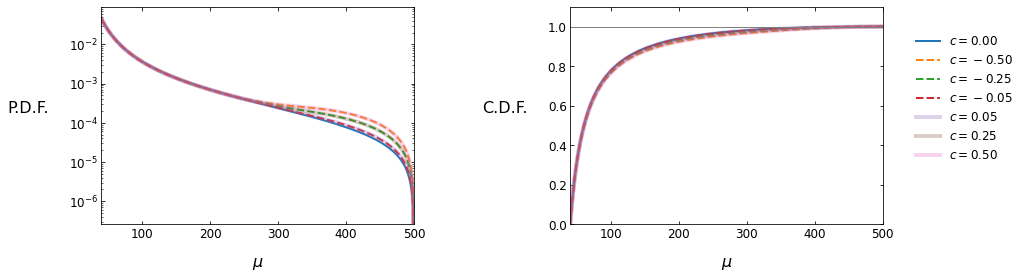

In [6]:
#  Plot PDF 

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)
ax2.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)

x  = np.linspace(mu_limits[0], mu_limits[-1], 500)
pdf_profile_SM, ymin, ymax = None, 1., 0.
for c in c_vals :
    pdf  = mu_pdf(x, c)
    cdf  = mu_cdf(x, c)
    ymax = np.max([ymax, np.max(pdf)])
    ymin = np.min([ymin, np.min([p for p in pdf if p>0])])
    if   c == 0 : 
        ax1.plot(x, pdf, "-" , lw=2, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "-" , lw=2, label=f"$c = {c:.2f}$")
        pdf_profile_SM = pdf
    elif c >  0 : 
        ax1.plot(x, pdf, "-" , lw=4, alpha=0.3, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "-" , lw=4, alpha=0.3, label=f"$c = {c:.2f}$")
    else        : 
        ax1.plot(x, pdf, "--", lw=2, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "--", lw=2, label=f"$c = {c:.2f}$")
ax1.set_xlim([x[0], x[-1]])
ax1.set_ylim([0.5*ymin, 2*ymax])
ax1.set_yscale("log")
ax1.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax1.set_ylabel("P.D.F.", labelpad=20, fontsize=16, ha="right", rotation=0)

ax2.set_xlim([x[0], x[-1]])
ax2.set_ylim([0, 1.1])
ax2.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax2.set_ylabel("C.D.F.", labelpad=20, fontsize=16, ha="right", rotation=0)
ax2.legend(loc=(1.09, 1-0.105*len(c_vals)), fontsize=12, frameon=False)
ax2.axhline(1, ls="-", lw=1, c="grey")

plt.subplots_adjust(hspace=0.01, wspace=0.5)
plt.show()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encoun

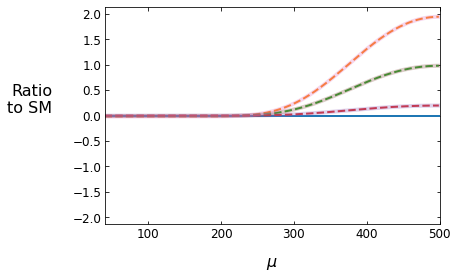

In [7]:
#  Plot PDF ratio to SM

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)

ymax = 0.
for c in c_vals :
    ratio  = (mu_pdf(x, c) / pdf_profile_SM) - 1.
    ymax = np.max([ymax, np.max(np.fabs(np.ma.masked_invalid(ratio)))])
    if   c == 0 : ax.plot(x, ratio, "-" , lw=2, label=f"$c = {c:.2f}$")
    elif c >  0 : ax.plot(x, ratio, "-" , lw=4, alpha=0.3, label=f"$c = {c:.1f}$")
    else        : ax.plot(x, ratio, "--", lw=2, label=f"$c = {c:.2f}$")
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([- 1.1*ymax, 1.1*ymax])
ax.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax.set_ylabel("Ratio\nto SM", labelpad=20, fontsize=16, ha="right", rotation=0)

plt.show()


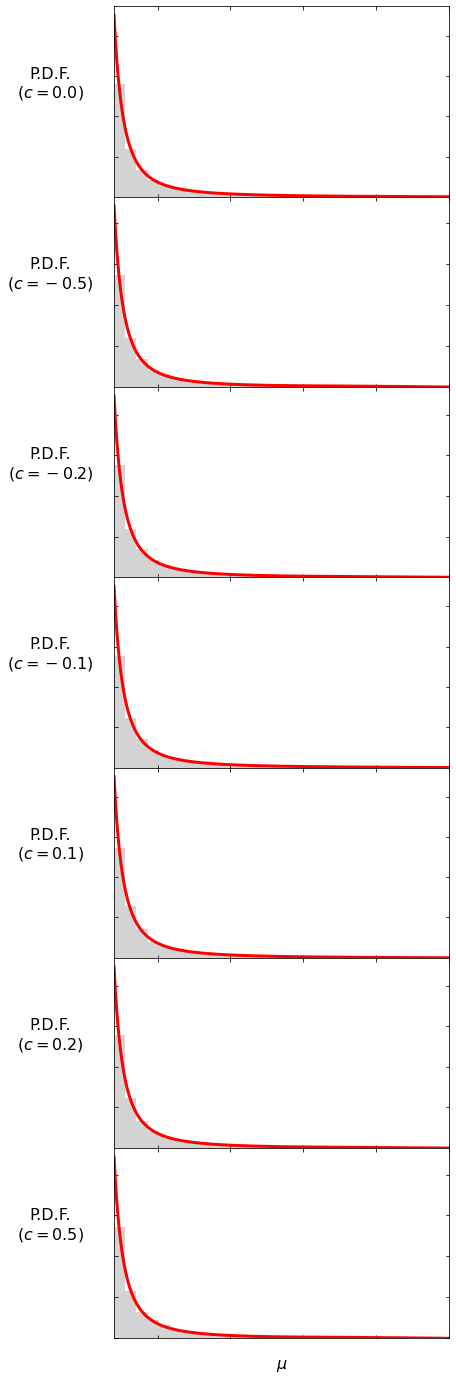

In [8]:
#  Throw and plot toys

datasets = {}

fig = plt.figure(figsize=(6, 4*len(c_vals)))
for ax_idx, c in enumerate(c_vals) :
    ax = fig.add_subplot(1+len(c_vals), 1, 1+ax_idx)
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)
    data = sample_pdf(num_samples, c)
    ax.hist(data, bins=np.linspace(mu_limits[0], mu_limits[-1], 31), density=True, color="lightgrey")
    ax.plot(x, mu_pdf(x, c), "-", lw=3, c="r")
    ax.set_ylabel(f"P.D.F.\n($c={c:.1f}$)", labelpad=60, fontsize=16, rotation=0)
    ax.set_xlim([x[0], x[-1]])  
    ax.set_xticklabels([]) 
    ax.set_yticklabels([])
    datasets[c] = data.reshape((len(data), 1))
    
ax.set_xlabel("$\mu$", labelpad=15, fontsize=16)

plt.subplots_adjust(hspace=0)
plt.show()


In [9]:

class whitening_method :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

whitening_gaus = whitening_method("gaus",          load_file=".white_funcs_paper_gaus.pickle", save_file=".white_funcs_paper_gaus.pickle", load_model_dir=".EWK_density_model_paper_gaus", save_model_dir=".EWK_density_model_paper_gaus")
whitening_step = whitening_method("step", 4, 3, 1, load_file=".white_funcs_paper_step.pickle", save_file=".white_funcs_paper_step.pickle", load_model_dir=".EWK_density_model_paper_step", save_model_dir=".EWK_density_model_paper_step")
whitening_methods = [whitening_step]


In [10]:
#  Plots config
#  TOYVAR1

intervals = []

minor_intervals = []

x_prime = 300


In [11]:

for white_meth in whitening_methods :
    
    whitening_funcs = None

    axis_configs = [[mu_limits[0], mu_limits[-1], whitening_num_points,  white_linear_fraction_data_space, white_linear_fraction_latent_space]]

    white_meth.observable_data, white_meth.white_data = {}, {}
    for c in c_vals :
        data = datasets[c]
        white_meth.observable_data [c] = data
        print(f"Whitening dataset for {c:.2f}")
        white_meth.white_data[c], whitening_funcs = whiten_axes (data, [float], axis_configs=axis_configs, whitening_funcs=whitening_funcs, 
                                                                 func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)
            
    if len(intervals) > 0 :
        white_meth.white_intervals = whiten_axes (np.array([[i[0]] for i in intervals]), [float], axis_configs=axis_configs, whitening_funcs=whitening_funcs, 
                                                  func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_intervals = []
    
    if len(minor_intervals) > 0 :
        white_meth.white_minor_intervals = whiten_axes (np.array([[i] for i in minor_intervals]), [float], axis_configs=axis_configs, whitening_funcs=whitening_funcs, 
                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_minor_intervals = []
        

Whitening dataset for 0.00
Whitening dataset for -0.50
Whitening dataset for -0.25
Whitening dataset for -0.05
Whitening dataset for 0.05
Whitening dataset for 0.25
Whitening dataset for 0.50


In [12]:
#  Weight all training points equally
#

for white_meth in whitening_methods :
    event_weights = np.ones(shape=(num_samples,))
    c_sf = np.max(np.fabs(c_vals))
    c_sf = 1./c_sf if (c_sf>0) else 1.
    white_meth.event_weights = {c:(1+np.fabs(c)*c_sf)*event_weights/np.sum(event_weights) for c in c_vals}
    

In [13]:
#  Save numbers required to plot whitening function
#

for white_meth in whitening_methods :

    alpha, beta , gamma      = white_meth.alpha, white_meth.beta, white_meth.gamma
    axmin, axmax, ax_npoints = mu_limits[0], mu_limits[-1], whitening_num_points
    ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
    data_frac_constant       = white_linear_fraction_data_space
    gauss_frac_constant      = white_linear_fraction_latent_space
    dataset   = white_meth.observable_data[0][:,0]
    weights   = white_meth.event_weights  [0]
    ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
    dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
    weights   = weights / np.sum(weights)
    func_form = white_meth.func_form
        
    print("Getting data c.d.f.")
    data_cdf = []
    for A in ax_scan_points :
        sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
        data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = data_frac_constant*constant_cdf + (1-data_frac_constant)*data_cdf
    
    white_meth.ax_scan_points = ax_scan_points
    white_meth.cdf_data, white_meth.cdf_data_linear, white_meth.cdf_x = data_cdf, constant_cdf, combined_cdf

    print("\nGetting latent c.d.f.")
    if func_form == "step" :
        white_space_x   = np.linspace(-5, 5, 201)
        Smooth_step_y   = 1. / (1 + np.exp((white_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(white_space_x+beta)*alpha-gamma))
        white_meth.white_space_y = Smooth_step_y
        Smooth_step_cdf = np.array([np.sum(Smooth_step_y[:i+1]) for i in range(len(Smooth_step_y))])
        Smooth_step_cdf = Smooth_step_cdf / Smooth_step_cdf[-1]
        Smooth_step_cdf[0] = 0.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Smooth_step_cdf
        white_meth.cdf_target    = Smooth_step_cdf
        white_meth.white_space_x = white_space_x
    else :
        white_space_x   = np.linspace(-5, 5, 201)
        white_meth.white_space_y = stats.norm.pdf(white_space_x)
        Gauss_cdf       = stats.norm.cdf(white_space_x)
        Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Gauss_cdf 
        white_meth.cdf_target    = Gauss_cdf
        white_meth.white_space_x = white_space_x
        
    white_meth.white_space_x = white_space_x
    white_meth.cdf_latent_linear, white_meth.cdf_u = constant_cdf, white_space_cdf
    
    print("Done")


Getting data c.d.f.
Scan point is: 500.0000  ----------
Getting latent c.d.f.
Done


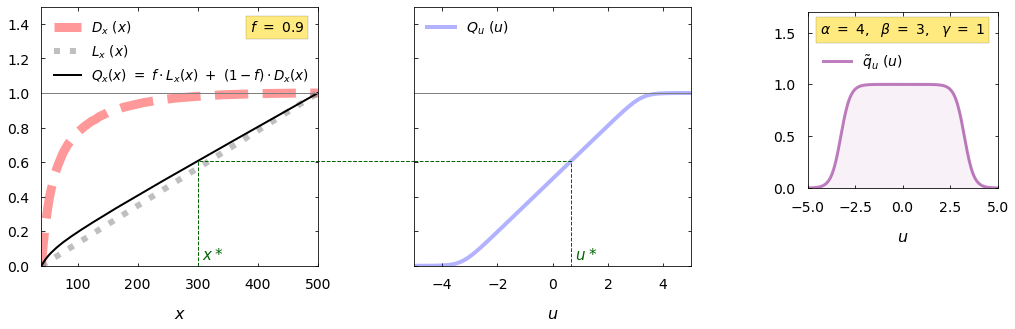

In [14]:
#  Plot whitening functions
#

for white_meth in whitening_methods :
    y_prime = np.interp(x_prime, white_meth.ax_scan_points, white_meth.cdf_x        )
    u_prime = np.interp(y_prime, white_meth.cdf_u         , white_meth.white_space_x)
    
    fig    = plt.figure(figsize=(14., 0.8*4.5))
    ax     = fig.add_axes([0.01, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.ax_scan_points
    ax.plot(plot_x, white_meth.cdf_data        , "-", linestyle="--", lw=9, c="r"   , alpha=0.4, label="$D_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_data_linear , "-", linestyle=":" , lw=6, c="grey", alpha=0.5, label="$L_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_x           , "-", linestyle="-" , lw=2, c="k"   , label="$Q_x(x) ~=~ f\cdot L_x(x) ~+~ (1-f)\cdot D_x(x)$")
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=13.5, frameon=False)
    ax.plot([x_prime, x_prime, 2*plot_x[-1]-plot_x[0]], [0, y_prime, y_prime], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    ax.text(0.95, 0.95, f"$f~=~{white_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    ax     = fig.add_axes([0.38, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.white_space_x
    ax.plot(plot_x, white_meth.cdf_u, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=14, frameon=False)
    ax.plot([plot_x[0], u_prime, u_prime], [y_prime, y_prime, 0], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    
    ax     = fig.add_axes([0.77, 0.31, 0.22*12./14., 0.68])
    ax.plot(white_meth.white_space_x, white_meth.white_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
    ax.fill_between(white_space_x, np.zeros(shape=white_meth.white_space_x.shape), white_meth.white_space_y, color="purple", alpha=0.05)
    ax.set_xlim([white_space_x[0], white_space_x[-1]])
    maxy = 1.7*np.max(white_meth.white_space_y)
    ax.set_ylim([0        , maxy])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc=(0.05, 0.63), fontsize=14, frameon=False) 
    ax.text(0.5, 0.95, r"$\alpha~="+f"~{white_meth.alpha:.0f}"+r",~~\beta ~="+f"~{white_meth.beta :.0f}"+r",~~\gamma~="+f"~{white_meth.gamma:.0f}$", ha="center", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    plt.subplots_adjust(wspace=0.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_functions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()

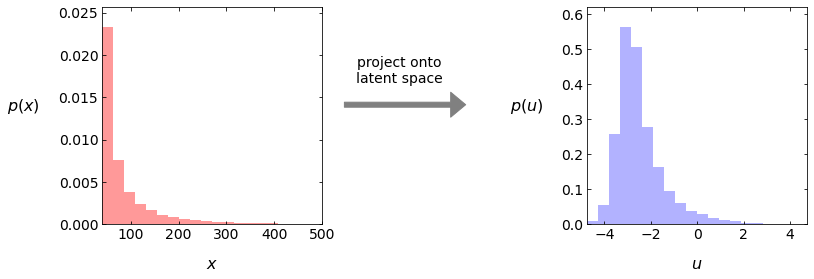

In [15]:
#  Weight all training points equally
#  -  and plot original / laten distributions
#

for white_meth in whitening_methods :
    fig = plt.figure(figsize=(10, 4))

    ax   = fig.add_subplot(1, 2, 1)
    bins = np.linspace(mu_limits[0], mu_limits[-1], 21)
    vals, _, _ = ax.hist(white_meth.observable_data[0], weights=white_meth.event_weights[0], bins=bins, density=True, color="r", alpha=0.4)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    
    for idx, i in enumerate(intervals) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
        ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
        ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
    
    for i in minor_intervals :
        ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
        
    ax   = fig.add_subplot(1, 2, 2)
    edge = np.max(np.fabs(white_meth.white_data[0]))
    bins = np.linspace(-edge, edge, 21)
    vals , _, _ = ax.hist(white_meth.white_data[0], weights=white_meth.event_weights[0], bins=bins, density=True, color="b", alpha=0.3)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]])), np.max(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]]))])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    
    for idx, (i, wi) in enumerate(zip(intervals, white_meth.white_intervals)) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
        xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
        label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
        line_pos         = wi[0], hmax
        ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
        ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
        
    for wi in white_meth.white_minor_intervals :
        ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
        
    ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
    
    ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
                xytext=(-1.1 , 0.55), textcoords="axes fraction",
                arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
    
    plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_distributions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()
    

In [16]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

def plot_mixture_model (savefig=None, log=False) :

    colours   = cm.get_cmap('brg', output_size_per_stage)   # 'hsv'
    newcolors = colours(np.linspace(0, 1, output_size_per_stage))
    x         = np.linspace(-6, 6, 241)
    bins      = np.linspace(-6, 6, 61)

    for white_meth in whitening_methods :

        fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        density_model = white_meth.density_model

        params = density_model.likelihood_models[0].get_gauss_params([0])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

        ds, weights = white_meth.white_data[0][:,0], white_meth.event_weights[0]
        
        print("fracs0", fracs)
        print("means0", means)
        print("sigmas0", sigmas)

        y1, int1 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals1, _, _     = ax0.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c=0$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y1   = y1 + yp
            int1 = int1 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax0.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax0.plot(x, y1, c="k", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c=0~)$")

        ax0.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax0.set_ylabel("$p(u)$", fontsize=16, labelpad=45, rotation=0)
        ax0.legend(loc="upper left", frameon=False, fontsize=14)

        rat_x, rat_y, rat_ey = [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey in zip(hvals1/int1 - 1, frac_errors*hvals1/int1) :
            rat_y .append(y )
            rat_y .append(y )
            rat_ey.append(ey)
            rat_ey.append(ey)
        rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

        ax2.axhline(0, linestyle="--", c="k", linewidth=3)
        ax2.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax2.set_yticks([-0.1, 0, 0.1])
        ax2.yaxis.set_ticklabels(["$-10\%$", "$0$", "$+10\%$"])
        ax2.plot(rat_x, rat_y, "-", c="darkgrey")
        ax2.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.5)
        ax2.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax2.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax2.set_ylabel(r"$\frac{p(u)~-~p_\phi(u)}{p_\phi(u)}$", fontsize=21, labelpad=70, rotation=0)
        ax2.set_ylim  ([-0.15, 0.15])

        params = density_model.likelihood_models[0].get_gauss_params([np.max(c_vals)])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]
        
        print("fracs1", fracs)
        print("means1", means)
        print("sigmas1", sigmas)

        ds, weights = white_meth.white_data[np.max(c_vals)][:,0], white_meth.event_weights[np.max(c_vals)]
        
        y2, int2 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals2, _, _     = ax1.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c=10$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y2   = y2 + yp
            int2 = int2 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax1.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax1.plot(x, y1, c="k"   , linewidth=3, linestyle="--")
        ax1.plot(x, y2, c="grey", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c=10~)$")

        ax1.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax1.legend(loc="upper left", frameon=False, fontsize=14)

        rat_y2, rat_ey2, rat_1_over_2, rat_data = [], [], [], []
        for y, ey, f, f_data in zip(hvals2/int2 - 1, frac_errors*hvals2/int2, int1/int2 - 1, hvals1/hvals2 - 1) :
            rat_y2      .append(y )
            rat_y2      .append(y )
            rat_ey2     .append(ey)
            rat_ey2     .append(ey)
            rat_1_over_2.append(f )
            rat_1_over_2.append(f )
            rat_data    .append(f_data)
            rat_data    .append(f_data)
        rat_y2, rat_ey2, rat_data = np.array(rat_y2), np.array(rat_ey2), np.array(rat_data)

        ax3.axhline(0    , linestyle="--", c="grey", linewidth=3)
        ax3.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax3.plot(rat_x, rat_y2  , "-" , c="darkgrey")
        #ax3.plot(rat_x, rat_data, "-" , c="blue"    )
        ax3.fill_between(rat_x, rat_y2-rat_ey2, rat_y2+rat_ey2, color="darkgrey", alpha=0.5)
        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax3.set_ylim  ([-0.15, 0.15])

        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)

        ax0.set_xlim([x[0], x[-1]])
        ax1.set_xlim([x[0], x[-1]])
        hmax   = np.max([np.max(hvals1), np.max(hvals2)])
        hmin   = np.min([np.min([v for v in hvals1 if v > 0]), np.min([v for v in hvals2 if v > 0])])
        hrange = hmax - hmin
        ax0.set_ylim([0, 1.4*hmax])
        ax1.set_ylim([0, 1.4*hmax])
        ax1.yaxis.set_ticklabels([])
        ax3.yaxis.set_ticklabels([])
        
        if log : 
            hrange = hmax / hmin
            ax0.set_yscale("log")
            ax1.set_yscale("log")
            ax0.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])
            ax1.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])

        plt.subplots_adjust(hspace=0.05, wspace=0.2, left=0.01, right=0.99)
        if type(savefig) is str :
            plt.savefig(savefig, bbox_inches="tight")
        plt.show()


INFO       DensityModel.construct      Set model name              : density_model
INFO       DensityModel.construct      Set model num_gaussians     : 25
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer      : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.build          Building model segment: density_model_observable0 for observable index 0
Projecting row index 0 from interval [-0.5, 

W0216 18:03:20.675695 4595987904 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses
-  observable logL are [-68.93985055], combined is -68.93985055465006
-  eval completed in 1s
fracs0 [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
means0 [-4.999639   -4.6390085  -4.2783785  -3.9177482  -3.557118   -3.1964877
 -2.8358574  -2.475227   -2.1145968  -1.7539667  -1.3933364  -1.0327061
 -0.67207587 -0.31144562  0.04918463  0.4098149   0.77044517  1.1310754
  1.4917057   1.8523359   2.2129662   2.5735965   2.9342268   3.294857
  3.6554873 ]
sigmas0 [0.04337563 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563
 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563
 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563
 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563 0.04337563
 0.04337563]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


fracs1 [0.04515744 0.04039028 0.03687963 0.05255887 0.03463185 0.04551869
 0.05120992 0.04417837 0.05281531 0.03404589 0.02944825 0.03826278
 0.04108494 0.02724286 0.03767288 0.0292563  0.03302909 0.04844569
 0.0403579  0.03549903 0.04417992 0.04129022 0.04818849 0.0341412
 0.03451416]
means1 [-4.797401   -4.6588597  -4.0312514  -4.0765643  -3.5274003  -3.654611
 -2.885715   -2.1851428  -2.1970928  -1.6783789  -1.4227978  -0.9538054
 -0.7405941  -0.4690162   0.11504114  0.43336448  0.5225314   1.2618233
  1.4371374   1.7792785   2.0891006   2.5551903   3.0494926   3.2159603
  3.6168156 ]
sigmas1 [0.04943313 0.04604181 0.04772737 0.03833712 0.03738753 0.05565254
 0.03749121 0.03096754 0.04060382 0.03695238 0.04158061 0.05163588
 0.04069519 0.05178606 0.03882496 0.04156117 0.03699449 0.03372022
 0.05924414 0.05314081 0.04732081 0.03494244 0.05041947 0.03698873
 0.05100516]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide


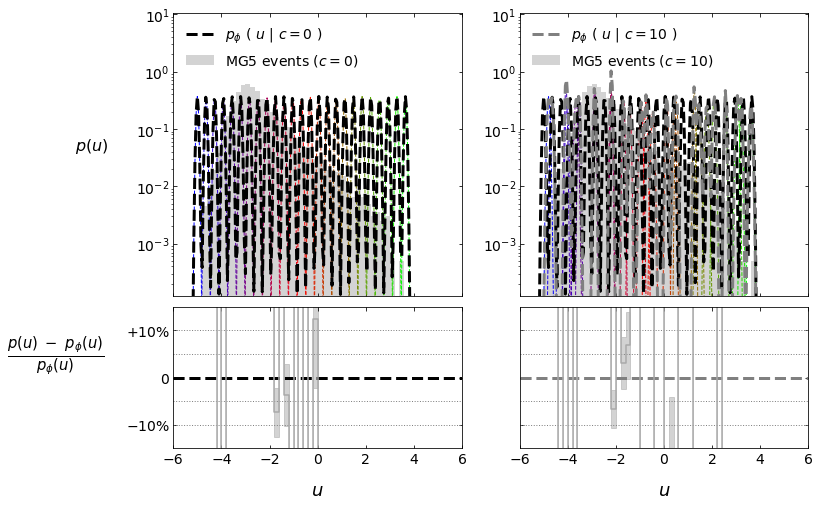

Setting batch size to 1000
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 42000 samples, validate on 28000 samples
Epoch 1/1000
42000/42000 [==============================] - 1s 13us/sample - loss: 6.8952e-04 - val_loss: 5.2985e-04
Epoch 2/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 4.7890e-04 - val_loss: 4.3918e-04
Epoch 3/1000
42000/42000 [=======================

Epoch 65/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8675e-04 - val_loss: 1.8681e-04
Epoch 66/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8675e-04 - val_loss: 1.8676e-04
Epoch 67/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8674e-04 - val_loss: 1.8675e-04
Epoch 68/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8675e-04 - val_loss: 1.8671e-04
Epoch 69/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8672e-04 - val_loss: 1.8670e-04
Epoch 70/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8671e-04 - val_loss: 1.8674e-04
Epoch 71/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8672e-04 - val_loss: 1.8677e-04
Epoch 72/1000
42000/42000 [==============================] - 0s 6us/sample - loss: 1.8671e-04 - val_loss: 1.8672e-04
Epoch 73/1000
42000/42000 [==============================] - 0s 

In [17]:
#  Load model if requested, otherwise build and fit
#

density_model.Gauss_width_reduction_factor = 8.

bias_init   = "zeros"

for white_meth in whitening_methods :
    range_limits = {}
    for idx in range(1) :
        all_data   = np.concatenate([item[:,idx] for c,item in white_meth.white_data.items()])
        imin, imax = np.min(all_data), np.max(all_data)
        irange     = imax - imin
        range_limits[idx] = [imin, imax]
    #
    #   Create density model  
    #
    white_meth.density_model = DensityModel(name             = "density_model", 
                                            num_gaussians    = output_size_per_stage, 
                                            num_conditions   = 1, 
                                            num_observables  = 1, 
                                            types            = [float],
                                            verbose          = True,
                                            learning_rate    = learning_rate,
                                            optimiser        = optimiser,
                                            range_limits     = range_limits,
                                            condition_limits = [[np.min(c_vals), np.max(c_vals)]],
                                            #kernel_initializer       = kernel_init,
                                            bias_initializer         = bias_init,
                                            activation               = "leakyrelu",
                                            A1                       = 5,
                                            A2                       = 5,
                                            B1                       = 5,
                                            B2                       = 5,
                                            C                        = 1,
                                            D2                       = 1,
                                            min_gauss_amplitude_frac = 0.,
                                            gauss_mean_scale         = 1./8.,
                                            gauss_frac_scale         = 1./8.,
                                            gauss_sigma_scale        = 1./8.,
                                            transform_min            = -2.,
                                            transform_max            = 2.)
        
    #
    #   Rebuild layers if they lead to INF/NaN initial loss for any datapoint
    #

    fit_X = np.concatenate([np.full(fill_value=c, shape=(len(d),1)) for c,d in white_meth.white_data.items()])
    fit_Y = np.concatenate([d for c,d in white_meth.white_data  .items()])
    fit_W = np.concatenate([d for c,d in white_meth.event_weights.items()])

    def get_losses (model) :
        losses = model.split_evaluator.predict([fit_X, fit_Y])
        losses = np.multiply(fit_W[:, np.newaxis], losses)
        losses = np.sum(losses, axis=0)
        return losses

    def reset_weights (model) :
        session = tf.compat.v1.keras.backend.get_session()
        for layer in model.layers: 
            if hasattr(layer, "kernel") :
                layer.kernel.initializer.run(session=session)
            if hasattr(layer, "bias") :
                layer.bias.initializer.run(session=session)
                    
    attempt, max_attempts = 0, 10
    while attempt < max_attempts :
        print("Evaluating losses")
        start_time = time.time()
        losses = get_losses(white_meth.density_model)
        print(f"-  observable logL are {losses[:-1]}, combined is {losses[-1]}")
        print(f"-  eval completed in {int(time.time() - start_time):.0f}s")
        indices_to_retry = [idx for idx, loss in zip(np.arange(1), losses) if not np.isfinite(loss)]
        if len(indices_to_retry) > 0 :
            print(f"-  rebuilding models for indices {', '.join([f'{idx}' for idx in indices_to_retry])}")
        else :
            attempt = max_attempts
        for idx in indices_to_retry :
            likelihood_model = white_meth.density_model.likelihood_models[idx]
            reset_weights (likelihood_model.model)
            
    #
    #   Plot density model
    #         
    plot_mixture_model(log=True)
                      
    #
    #   Fit density model
    #
    for batch_size in batch_sizes :
        print(f"Setting batch size to {batch_size}")
        white_meth.density_model.fit(white_meth.white_data   , 
                                     white_meth.event_weights,
                                     max_epochs_per_observable = max_epochs,
                                     early_stopping_patience   = early_stopping_patience,
                                     early_stopping_min_delta  = early_stopping_min_delta,
                                     validation_split          = validation_split,
                                     batch_size_per_observable = batch_size)


fracs0 [0.00063958 0.0032994  0.01648526 0.05472768 0.11196275 0.18750134
 0.13895714 0.14648107 0.11823077 0.07541049 0.03135185 0.04999785
 0.00953859 0.00267319 0.03190653 0.00095638 0.00122615 0.00460323
 0.00399816 0.00471073 0.00165737 0.00255431 0.00069757 0.00022554
 0.00020703]
means0 [-4.7577643  -4.4301453  -4.017955   -3.6494145  -3.3606439  -3.0746512
 -2.8123357  -2.5653749  -2.2725875  -1.8683877  -1.4928279  -1.0937817
 -0.61854684 -0.35649785  0.0573926   0.5510341   0.7255371   1.0359538
  1.4332275   1.810699    2.2579365   2.6041384   2.9464197   3.3420675
  3.5918908 ]
sigmas0 [0.10838778 0.15897755 0.15333606 0.16324626 0.14556067 0.15526804
 0.15676463 0.18320777 0.20146377 0.21136089 0.18898302 0.30281875
 0.17833848 0.13335148 0.514312   0.11776737 0.09522348 0.23974057
 0.12341015 0.11599576 0.11279821 0.1716856  0.15013485 0.04021756
 0.03893882]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


fracs1 [8.2926003e-05 1.2311349e-03 1.8184261e-02 5.7822485e-02 5.2407429e-02
 1.6310720e-01 1.5889606e-01 1.5878528e-01 1.3960132e-01 8.3719887e-02
 2.4533011e-02 7.4498698e-02 2.4784643e-03 7.2095718e-04 5.8156636e-02
 1.3712425e-04 1.3936330e-04 1.8509781e-03 1.1225245e-03 1.5989683e-03
 3.5048209e-04 4.6130983e-04 8.3460036e-05 1.2925157e-05 1.7053821e-05]
means1 [-4.6079035  -4.3301053  -3.8256388  -3.536561   -3.279215   -3.1535273
 -2.814569   -2.6041703  -2.2801628  -1.9549952  -1.4837985  -1.0677342
 -0.6850253  -0.54799485  0.10981125  0.6360879   0.6545796   0.9631834
  1.4898914   1.8246164   2.261652    2.6345873   2.8020716   3.419058
  3.5935323 ]
sigmas1 [0.17561713 0.46106893 0.4463275  0.3856221  0.26944685 0.29376265
 0.28505918 0.4831514  0.5061939  0.64986503 0.5246069  1.2543362
 0.3748675  0.32197133 1.4825437  0.25085074 0.15244848 0.62217796
 0.28515154 0.26991126 0.22570927 0.30715027 0.37561247 0.04022088
 0.03830864]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


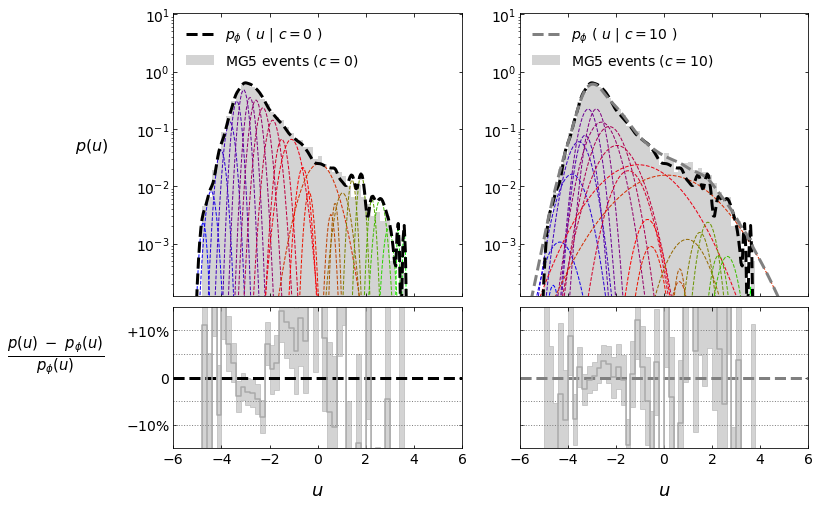

In [18]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

plot_mixture_model(log=True)


In [19]:
#  Generate a large number of datapoints at 0.
#

n_gen = 2000000

print(f"Generating {n_gen} fake datapoints for c = 0")
start = time.time()
fake_white_datapoints_SM = white_meth.density_model.sample(n_gen, 0)
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

fake_white_datapoints = {}
for c in c_vals :
    start = time.time()
    fake_white_datapoints [c] = white_meth.density_model.sample(n_gen, c)
    end = time.time()
    print(f"{n_gen} datapoints evaluated at {c} in {(end-start):.2f}s")
    

Generating 2000000 fake datapoints for c = 0
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints generated at (0, 0) in 12s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at 0.0 in 12.76s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at -0.5 in 13.00s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at -0.25 in 12.75s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at -0.05 in 12.80s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at 0.05 in 12.74s
INFO       DensityModel.sample         Sampling 2000000 datapoints, observable index is 0
2000000 datapoints evaluated at 0.25 in 12.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/li

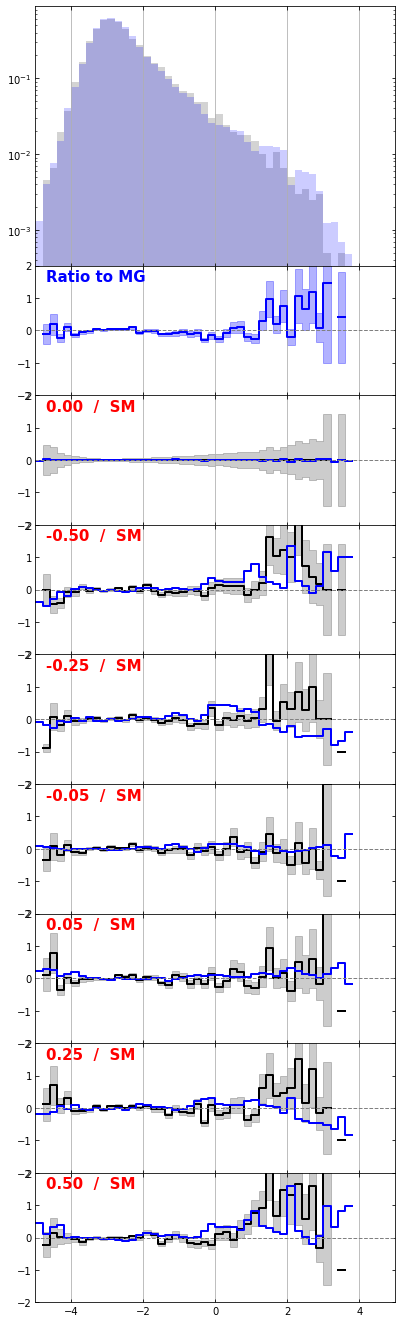

In [20]:

fig = plt.figure(figsize=(5, 2*(2+len(c_vals))))

pad_height = 1. / (3+len(c_vals))
lower      = 1. - 2*pad_height
ax = fig.add_axes([0, lower, 1, 2*pad_height])

bins = np.linspace(-5, 5, 51)
def get_histo (ds, weights=None) :
    if type(weights) == type(None) : weights = np.ones_like(ds)
    weights.reshape(ds.shape)
    bin_entries , _  = np.histogram(ds, weights=weights        , bins=bins)
    bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
    frac_errors      = np.sqrt(bin_variance) / bin_entries
    return bin_entries / np.sum(weights), frac_errors

ds, weights                          = white_meth.white_data[0][:,0], white_meth.event_weights[0]
bin_entries, frac_errors             = get_histo(ds, weights)
bin_entries_model, frac_errors_model = get_histo(fake_white_datapoints_SM)
ax.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins)
ax.hist(fake_white_datapoints_SM, density=True, color="blue", alpha=0.2, bins=bins)

ax.set_yscale("log")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])

lower = lower - pad_height
ax    = fig.add_axes([0, lower, 1, pad_height]) 
ratio_to_MG       = bin_entries_model / bin_entries
ratio_to_MG_error = ratio_to_MG*np.sqrt(frac_errors*frac_errors + frac_errors_model*frac_errors_model)      
rat_x, rat_y, rat_ey = [], [], []
for idx, b in enumerate(bins) :
    rat_x.append(b)
    if (idx==0) or (idx==len(bins)-1) : continue
    rat_x.append(b)
for y, ey in zip(ratio_to_MG - 1, ratio_to_MG_error) :
    rat_y  .append(y  )
    rat_y  .append(y  )
    rat_ey .append(ey )
    rat_ey .append(ey )
rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)
    
ax.plot(rat_x, rat_y, lw=2, color="b")
ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="b", alpha=0.3)
ax.axhline(0, ls="--", lw=1, c="grey")
ax.text(0.03, 0.97, "Ratio to MG", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="b", weight="bold")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])

for c in c_vals :
    lower = lower - pad_height
    ax = fig.add_axes([0, lower, 1, pad_height])
    
    ds, weights = white_meth.white_data[c][:,0], white_meth.event_weights[c]
    this_bin_entries, this_frac_errors = get_histo(ds, weights)
    ratio_to_SM       = this_bin_entries / bin_entries
    ratio_to_SM_error = ratio_to_SM*np.sqrt(frac_errors*frac_errors + this_frac_errors*this_frac_errors)
    
    this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints[c])
    ratio_to_SM_model       = this_bin_entries_model / bin_entries_model
    ratio_to_SM_error_model = ratio_to_SM_model*np.sqrt(frac_errors_model*frac_errors_model + this_frac_errors_model*this_frac_errors_model)
    
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = [], [], [], [], []
    for idx, b in enumerate(bins) :
        rat_x.append(b)
        if (idx==0) or (idx==len(bins)-1) : continue
        rat_x.append(b)
    for y, ey, ym, eym in zip(ratio_to_SM - 1, ratio_to_SM_error, ratio_to_SM_model - 1, ratio_to_SM_error_model) :
        rat_y  .append(y  )
        rat_y  .append(y  )
        rat_ey .append(ey )
        rat_ey .append(ey )
        rat_ym .append(ym )
        rat_ym .append(ym )
        rat_eym.append(eym)
        rat_eym.append(eym)
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = np.array(rat_x), np.array(rat_y), np.array(rat_ey), np.array(rat_ym), np.array(rat_eym)
    
    ax.plot(rat_x, rat_y, lw=2, color="k")
    ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="k", alpha=0.2)
    ax.plot(rat_x, rat_ym, lw=2, color="b")
    ax.axhline(0, ls="--", lw=1, c="grey")
    ax.text(0.03, 0.97, f"{c:.2f}  /  SM", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="r", weight="bold")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 2])
        
plt.show()
